In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import tarfile
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (maps, data, data_misfit, inverse_problem, regularization, optimization, directives, inversion,)
mpl.rcParams.update({"font.size": 14})
import pyvista as pv

##### (1) Defining Input Data Location

In [19]:
output_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data"
boundary_loc = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Boundary5_south_For_Magnetic_Inversion.bln"  # Use Boundary1 for residual study

In [21]:
topo_filename = output_dir + r"\SimPEG_Input\magnetics_topo_100m.txt"
data_filename = output_dir + r"\SimPEG_Input\magnetics_data_100m.obs"

In [23]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

###### (1A) Loading Localized Boundary within which Magnetic Inversion will be run

In [25]:
with open(boundary_loc, 'r') as f:
    lines = f.readlines()

boundary_coords = []
for line in lines:
    parts = line.replace(',', ' ').split()
    nums = [float(p) for p in parts]
    boundary_coords.append(nums)

boundary_coords = np.array(boundary_coords)

In [28]:
boundary_polygon = Polygon(boundary_coords)

###### (1B) Clipping data inside the Polygon

In [31]:
topo_xyz

array([[7.24646098e+05, 1.53911146e+06, 6.71200000e+02],
       [7.72203206e+05, 1.68720062e+06, 4.14600000e+02],
       [7.57578565e+05, 1.73706228e+06, 3.87100000e+02],
       ...,
       [6.81387903e+05, 1.56371140e+06, 6.10600000e+02],
       [6.90263838e+05, 1.55096016e+06, 5.94100000e+02],
       [7.61855767e+05, 1.65733018e+06, 3.90100000e+02]])

In [33]:
inside_topo = np.array([boundary_polygon.contains(Point(x, y)) for x, y, z in topo_xyz])
topo_xyz_clipped = topo_xyz[inside_topo]

In [34]:
inside_dobs = np.array([boundary_polygon.contains(Point(x, y)) for x, y, *_ in dobs])
dobs_clipped = dobs[inside_dobs]

In [35]:
# Define receiver locations and observed data
receiver_locations = dobs_clipped[:, 0:3]
dobs = dobs_clipped[:, -1]

##### (2) Plotting Polygon 

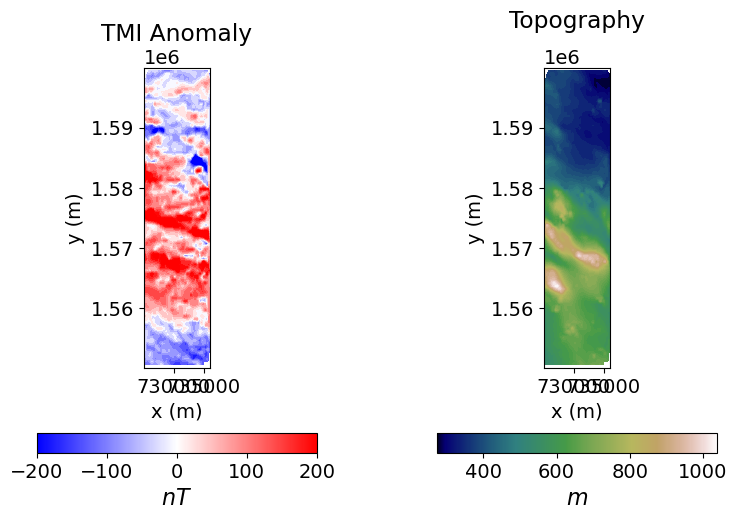

In [37]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

v_max = np.max(np.abs(dobs))
norm1 = mpl.colors.Normalize(vmin=-200, vmax=200)

plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=False,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm1}
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$nT$", size=16)

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz_clipped[:, 0:2],
    topo_xyz_clipped[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz[:, -1]), vmax=np.max(topo_xyz[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Maps\TMI Anomaly vs Topography for South-Boundary.png", dpi=400)
plt.show()

##### (3) Defining uncertainity

In [43]:
dobs.min(), dobs.max()

(-749.9504, 406.5127)

In [45]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.002 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 1.4999007999999998


##### (4) Survey Definition

In [48]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field
inclination = 33.5  # inclination [deg]
declination = 0.3  # declination [deg]
amplitude = 43800   # amplitude [nT]        #orignally it was 43800

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=amplitude,
    inclination=inclination,
    declination=declination,
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [50]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

##### (5) Designing Mesh

In [53]:
x_min, x_max = topo_xyz_clipped[:,0].min(), topo_xyz_clipped[:,0].max()
y_min, y_max = topo_xyz_clipped[:,1].min(), topo_xyz_clipped[:,1].max()
z_min, z_max = topo_xyz_clipped[:,2].min(), topo_xyz_clipped[:,2].max()

print(f"X Range: {x_min:.0f} to {x_max:.0f}")
print(f"Y Range: {y_min:.0f} to {y_max:.0f}")
print(f"Z Range (elevation): {z_min:.0f} to {z_max:.0f}")

X Range: 725003 to 735995
Y Range: 1550033 to 1599988
Z Range (elevation): 550 to 856


In [275]:
# Generate tensor mesh with top at z = 0 m
dh = 250  # minimum cell size
dz = 200
npad = 1
hx = [(dh, npad, -1.3), (dh, 45), (dh, npad, 1.3)]  # discretization along x
hy = [(dh, npad, -1.3), (dh, 200), (dh, npad, 1.3)]   # discretization along y
hz = [(dz, 1, -1.3), (dz, 29)]                   # discretization along z

In [277]:
origin_x = topo_xyz_clipped[:,0].min() - npad * dh
origin_y = topo_xyz_clipped[:,1].min() - npad * dh
origin_z = -5000                                    #topo_xyz_clipped[:,2].max() + npad * dz

In [279]:
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

In [281]:
tensor_mesh.origin = np.r_[origin_x, origin_y, origin_z]

In [283]:
tensor_mesh

TensorMesh: 284,820 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     47    724,752.56    736,652.56    250.00    325.00    1.30
   y    202  1,549,783.13  1,600,433.13    250.00    325.00    1.30
   z     30     -5,000.00      1,060.00    200.00    260.00    1.30

##### (6) Active Cell Selection

In [286]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

In [287]:
n_tensor_active

266311

##### (7) Mapping Active Cells

In [289]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

##### (8) Reference Model (A-Priori Model)

In [294]:
starting_tensor_model =  0.002 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [296]:
# Mapping to ignore inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

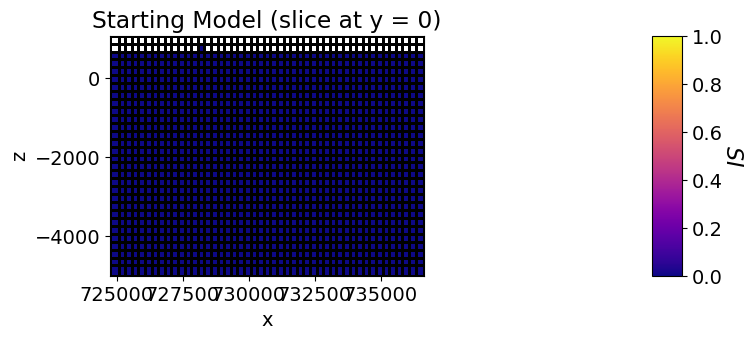

In [300]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
yind = 100
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind = yind,    #int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(1.5)
ax2.set_aspect(8)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Initial Model at y = {yind}  with gridsize_{dh,dh,dz}m.png",dpi=200)
plt.show()

In [302]:
simulation_L2 = magnetics.simulation.Simulation3DIntegral(survey=survey, mesh=tensor_mesh, model_type="scalar",
    chiMap=tensor_model_map, ind_active=active_tensor_cells, engine="choclo",)

In [304]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

In [306]:
reg_L2 = regularization.WeightedLeastSquares(tensor_mesh, active_cells=active_tensor_cells, length_scale_x=1.0, length_scale_y=1.0,
    length_scale_z=1.0, reference_model=reference_tensor_model, reference_model_in_smooth=False,)

In [307]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=100, lower=0.0, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

In [310]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [312]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

In [314]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


C:\Users\Kunal\anaconda3\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.96e+02  1.25e+07  4.27e+04  2.51e+07    3.67e+06      0              
   1  1.48e+02  1.07e+07  3.10e+03  1.12e+07    1.48e+07      0              
   2  7.41e+01  8.97e+06  1.13e+04  9.81e+06    1.13e+07      0              
   3  3.70e+01  6.96e+06  3.08e+04  8.11e+06    8.89e+06      0   Skip BFGS  
   4  1.85e+01  4.88e+06  7.12e+04  6.20e+06    7.06e+06      0   Skip BFGS  
   5  9.26e+00  3.08e+06  1.40e+05  4.37e+06    5.26e+06      0   Skip BFGS  
   6  4.63e+00  1.77e+06  2.38e+05  2.87e+06    3.71e+06      0   Skip BFGS  
   7  2.31e+00  9.24e+05  3.63e+05  1.76e+06    2.40e+06      0   Skip BFGS  
   8  1.16e+00  4.51e+05  5.01e+05  1.03e+06    1.48e+06      0   Skip BFGS  
   9  5.79e-01  2.07e+05

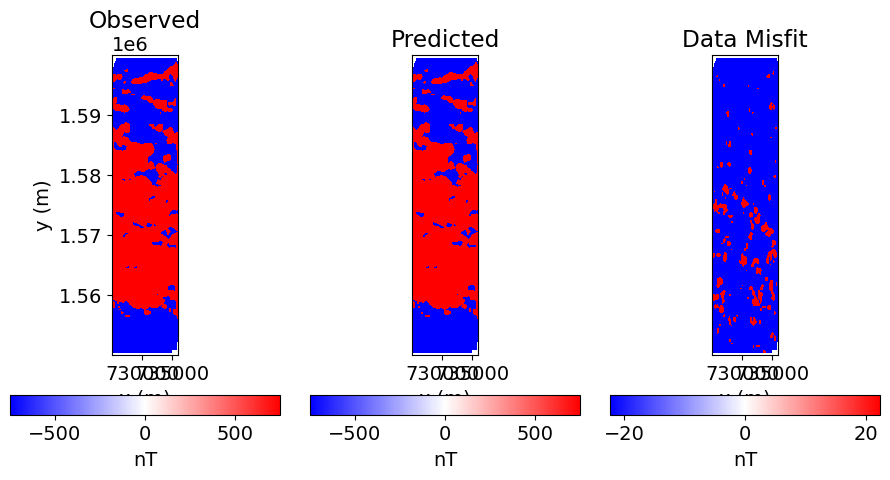

In [315]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs*1e9, dpred*1e9, (dobs - dpred)*1e9]

fig = plt.figure(figsize=(10, 4))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["nT", "nT", "nT"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]


for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], labelpad=5)
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Data Misfit.png",dpi=200)
plt.show()

In [316]:
recovered_tensor_model.max(), dpred, tensor_plotting_map

(0.10725328636842481,
 array([ -18.196445,  -80.708725, -111.85022 , ...,  139.5628  ,
         214.85797 ,  187.34555 ], dtype=float32),
 <simpeg.maps._injection.InjectActiveCells at 0x1b421893230>)

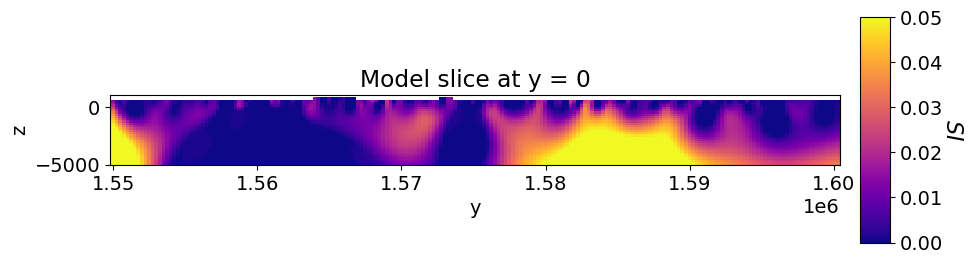

In [429]:
# Plot Recovered Model
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
yind = 0
norm = mpl.colors.Normalize(
    vmin=0, vmax=0.05
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="X",
    ax=ax1,
    ind=yind ,           #int(tensor_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title(f"Model slice at y = {yind}")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(0.8)
ax2.set_aspect(150)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Inverted Magnetic Susc Model Slice at {yind} South Area_X-view.png",dpi=300)
plt.show()

In [330]:
for yind in range(0, tensor_mesh.shape_cells[1]):  # Loop from 0 to 116 inclusive
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
    
    norm = mpl.colors.Normalize(vmin=0, vmax=0.05)
    
    tensor_mesh.plot_slice(
        tensor_plotting_map * recovered_tensor_model,
        normal="Y",
        ax=ax1,
        ind=yind,
        grid=False,
        pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
    )
    ax1.set_title(f"Model slice at y = {yind}")
    
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(
        ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
    ax1.set_aspect(0.8)
    ax2.set_aspect(150)
    
    output_path = rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Inverted Magnetic Susc Model Slice at {yind} Wajrakur Area.png"
    plt.savefig(output_path, dpi=300)
    plt.close(fig)  # Close the figure to release memory


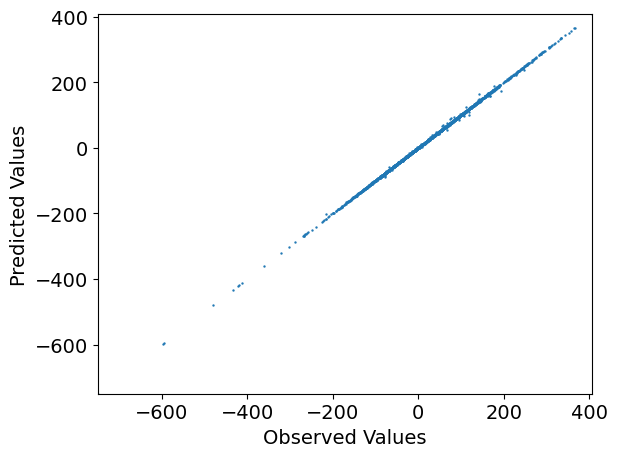

In [331]:
plt.scatter(dobs, dpred, s=0.5)
plt.xlim(dobs.min(),dobs.max())
plt.ylim(dobs.min(),dobs.max())
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\dobs-vs-dpred.png")
plt.show()

In [332]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

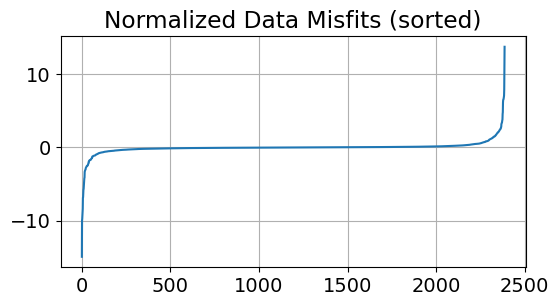

In [333]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Normalized Data Misfits.png")
plt.show(fig)

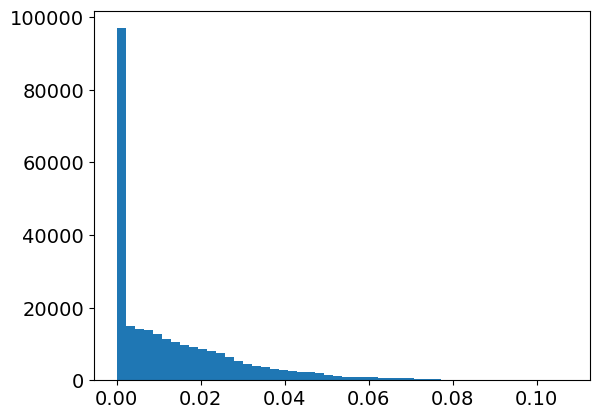

In [340]:
plt.hist(model_3d,bins=50)
plt.show()

In [342]:
# 1. Inject recovered model to full mesh (NaN in inactive)
model_3d = tensor_plotting_map * recovered_tensor_model

In [508]:
# 2. Apply mask: only retain values between 0.05 and 0.1
model_masked = np.where((model_3d >= 0.02) & (model_3d <= 0.06), model_3d, np.nan)

# 3. Get voxel centers
x, y, z = tensor_mesh.cell_centers[:, 0], tensor_mesh.cell_centers[:, 1], tensor_mesh.cell_centers[:, 2]
values = model_masked

In [510]:
# 4. Filter only finite (non-NaN) voxels
mask = np.isfinite(values)
points = np.vstack([x[mask], y[mask], z[mask]]).T
values = values[mask]

In [512]:
# 5. Create point cloud for smooth rendering
cloud = pv.PolyData(points)
cloud['susceptibility'] = values

C:\Users\Kunal\anaconda3\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\Kunal\anaconda3\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


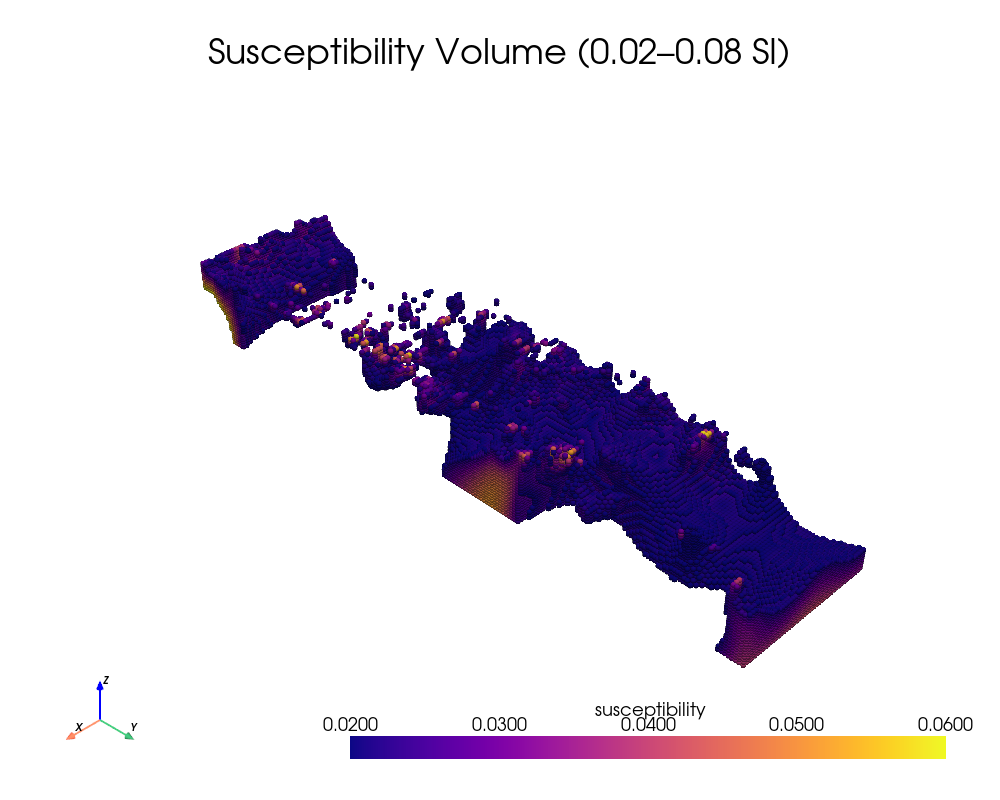

In [514]:
# 6. Start PyVista plot
plotter = pv.Plotter(window_size=(1000, 800))
plotter.add_mesh(cloud,
    scalars='susceptibility',
    cmap='plasma',
    render_points_as_spheres=True,
    point_size=6,
    nan_color='white'
)
plotter.add_axes()
plotter.view_vector([1, 1, 1])
plotter.add_title("Susceptibility Volume (0.02–0.08 SI)", font_size=14)
plotter.set_background("white")
plotter.show_axes()
plotter.show()

In [516]:
# === 1. Interpolate Topo Points onto a Grid ===
topo_x, topo_y, topo_z = topo_xyz_clipped[:, 0], topo_xyz_clipped[:, 1], topo_xyz_clipped[:, 2]

In [518]:
# Create a regular grid covering the topo extent
grid_res = 100  # adjust as needed
x_range = np.linspace(topo_x.min(), topo_x.max(), grid_res)
y_range = np.linspace(topo_y.min(), topo_y.max(), grid_res)
X_grid, Y_grid = np.meshgrid(x_range, y_range)


In [522]:
from scipy.interpolate import griddata
# Interpolate z values onto grid
Z_grid = griddata((topo_x, topo_y), topo_z, (X_grid, Y_grid), method='cubic')

In [524]:
# Remove NaNs from grid for surface mesh creation
mask = ~np.isnan(Z_grid)
surf = pv.StructuredGrid(X_grid[mask], Y_grid[mask], Z_grid[mask])
surf = pv.StructuredGrid(X_grid, Y_grid, Z_grid)  # optional full grid with NaNs

In [530]:
# === 2. Create the 3D susceptibility grid ===
model_3d = tensor_plotting_map * recovered_tensor_model
masked_model = np.where((model_3d >= 0.05) & (model_3d <= 0.1), model_3d, np.nan)

nx, ny, nz = tensor_mesh.shape_cells
X = tensor_mesh.gridCC[:, 0].reshape((nx, ny, nz), order='F')
Y = tensor_mesh.gridCC[:, 1].reshape((nx, ny, nz), order='F')
Z = tensor_mesh.gridCC[:, 2].reshape((nx, ny, nz), order='F')
V = masked_model.reshape((nx, ny, nz), order='F')

# Create the 3D grid (coordinates)
grid = pv.StructuredGrid(X, Y, Z)

# Attach full susceptibility volume, reshape properly
full_model = tensor_plotting_map * recovered_tensor_model
V_full = full_model.reshape((nx, ny, nz), order='F')  # Ensure proper reshaping

grid["susceptibility"] = V_full  # This will match point count now

ValueError: Number of scalars (47) must match either the number of points (284820) or the number of cells (268134).

In [536]:
V.shape, V_full.shape

((47, 202, 30), (47, 202, 30))